In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib import tri
from numba import cuda, float32
import cmocean.cm as cm
from scipy.spatial import ConvexHull
from scipy.interpolate import LinearNDInterpolator
import multiprocessing as mp
from rk4_functions import rk4

%matplotlib inline

\begin{equation}
\vec{v}(r,\theta) = sin(r)
\end{equation}

Note: need to look at the temporal autocorrelation of the model errors to get a sense of what maximum acceleration criterion makes sense (Nov 29 2021).

Can most likely reverse engineer the maximum acceleration from the autocovariance by assuming/fitting a simple form of the autocovariance function, say exponential decay.

\begin{equation}
e^{-Bt} = \frac{\frac{1}{N}\sum_{i=1}^N u(t)u(t+\tau)}{\sigma_u^2}
\end{equation}

(Double check the above formula, will likely need to write in integral form to get $\frac{du(t)}{dt}$)
(use chain rule for $\frac{du(t+\tau)}{dt}$)

C:\Users\hauke\AppData\Local\Temp/ipykernel_14560/2519412947.py:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc = ax.pcolormesh(xg[0,:,:],yg[0,:,:],spd[0,:,:],cmap=cm.balance,alpha=0.5)


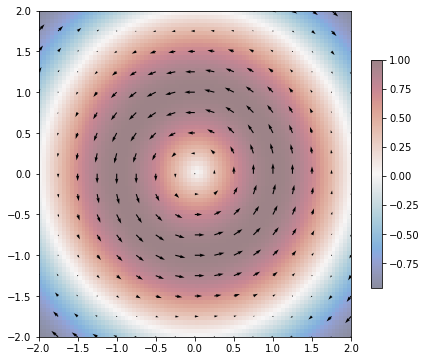

In [2]:
extent = 2.
res = 0.05
s = 5
end_time = 2. * np.pi

tg,xg,yg = np.meshgrid(np.linspace(0.,end_time,2),
                       np.arange(-extent,extent + res / 2.,res),
                       np.arange(-extent,extent + res / 2.,res),indexing='ij')

r = np.sqrt(xg**2. + yg**2.)  
spd = np.sin(np.pi * r / extent)
theta = np.arctan2(yg,xg) + np.pi/2.
u = spd * np.cos(theta)
v = spd * np.sin(theta)

fig,ax = plt.subplots(figsize=(7,6))
pc = ax.pcolormesh(xg[0,:,:],yg[0,:,:],spd[0,:,:],cmap=cm.balance,alpha=0.5)
plt.colorbar(pc,shrink=0.7)
ax.quiver(xg[0,::s,::s],yg[0,::s,::s],u[0,::s,::s],v[0,::s,::s],scale=30.)

In [7]:
grid = (tg,xg,yg)

parallel = True

start_pos = (0.,1.)
xy = [[[start_pos[0],start_pos[1]]]]

dt = np.pi / 30.
N_revolutions = 0.25
T = 2.**(N_revolutions - 1) * 2. * np.pi
N = int(T/dt)+1
time_vel = np.linspace(0.,T,N)

fractal_dimension = 1.5
ts_freq = 1.   #measurement interval of the error time series (fictitious here)
nPg = 5
nPl = 20

noise_level = 0.2
local_noise = np.sqrt((dt/ts_freq)**(2./fractal_dimension) * noise_level**2. / 3)

#global_offsets = rk4().random_gaussian_perturbation(nPg,noise_level)
#local_offsets = rk4().random_gaussian_perturbation(nPl,local_noise)
global_offsets = rk4().uniform_perturbation(nPg,noise_level)
local_offsets = rk4().uniform_perturbation(nPl,local_noise)
previous_offsets = [0.]

i = 1
while i < N:
    step_xy = []
    offset_tracker = []
    if i == 1:
        iterlen = len(global_offsets)
    else:
        iterlen = len(local_offsets)
    for po,xy1 in zip(previous_offsets,xy[-1]):
        pos = []
        if parallel:
            with mp.Pool(processes=12) as pool:
                iterator = [pool.apply_async(rk4().compute_possibility,
                                           args=(n,i,u,v,grid,time_vel,xy1,dt,
                                                 po,global_offsets,local_offsets,)) for n in range(iterlen)]
                results = [r.get() for r in iterator]
            for r in results:
                pos.append([r[0],r[1]])
                offset_tracker.append(r[2])
        else:
            for n in range(iterlen):
                xx,yy,off = rk4().compute_possibility(n,i,u,v,grid,time_vel,xy1,dt,po,global_offsets,local_offsets)
                pos.append([xx,yy])
                offset_tracker.append(off)
        step_xy = step_xy + pos
    ptsa = np.asarray(step_xy)
    if i == 8:
        i = N
    vela = np.asarray(offset_tracker)
    c = np.where(np.isnan(ptsa[:,0]))[0]
    if len(c) > 0:
        ptsa = np.delete(ptsa,c,axis=0)
        vela = np.delete(vela,c,axis=0)
    if len(ptsa) == 0:
        print('no points in domain')
        break
    
    hull = ConvexHull(ptsa)
    vertices = ptsa[hull.vertices,:]; vertices = np.vstack([vertices,vertices[0,:]]); bbp = Path(vertices)
    vel_interp = LinearNDInterpolator((ptsa[:,0],ptsa[:,1]),vela)
    step_x = np.linspace(vertices[:,0].min(),vertices[:,0].max(),nPg)
    step_y = np.linspace(vertices[:,1].min(),vertices[:,1].max(),nPg)
    
    out_pos = []
    previous_offsets = np.array([]).astype(complex)
    for jj in range(nPg):
        for ii in range(nPg):
            if bbp.contains_point((step_x[jj],step_y[ii])):
                out_pos.append([step_x[jj],step_y[ii]])
                previous_offsets = np.hstack([previous_offsets,vel_interp(step_x[jj],step_y[ii])])
                
    xy.append(out_pos)
    
    i += 1
    if float(i) % 10. == 0.:
        print(i)

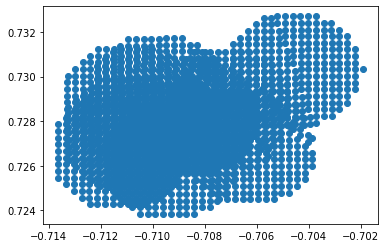

In [8]:
plt.scatter(ptsa[:,0],ptsa[:,1])

In [30]:
vela = np.asarray(offset_tracker)
trian = tri.Triangulation(ptsa[:,0],ptsa[:,1])

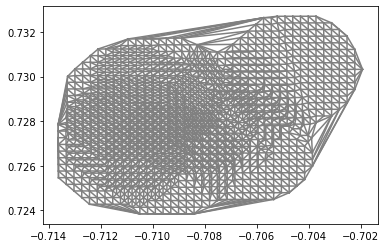

In [31]:
for e in trian.edges:
    plt.plot([ptsa[e[0],0],ptsa[e[1],0]],[ptsa[e[0],1],ptsa[e[1],1]],color='0.5')

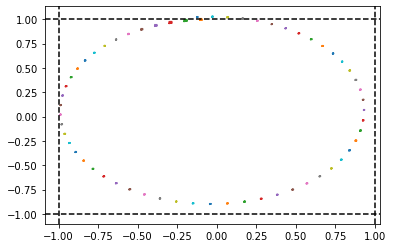

In [7]:
for xy1 in xy:
    arr1 = np.asarray(xy1)
    arr1 = np.vstack([arr1,arr1[0,:]])
    plt.plot(arr1[:,0],arr1[:,1])
for ii in [-1.,1.]:
    plt.axhline(ii,color='k',ls='--')
    plt.axvline(ii,color='k',ls='--')

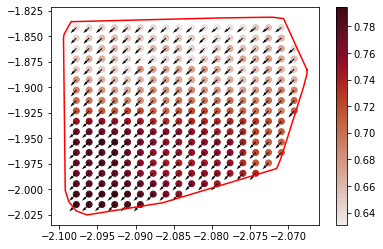

In [20]:
xp = np.asarray(xy[-1])[:,0]
yp = np.asarray(xy[-1])[:,1]
pc = plt.scatter(xp,yp,c = np.absolute(previous_offsets),cmap=cm.amp)
plt.colorbar(pc)
plt.plot(vertices[:,0],vertices[:,1],color='r')
plt.quiver(xp,yp,previous_offsets.real,previous_offsets.imag)
#plt.scatter(ptsa[:,0],ptsa[:,1],color='g',alpha=0.5)

In [ ]:
grid = (tg,xg,yg)
dt = np.pi / 30.
N_revolutions = 1
T = 2.**(N_revolutions - 1) * 2. * np.pi
N = int(T/dt)+1
time_vel = np.linspace(0.,T,N)

In [ ]:
xs, ys = (0.,1.)
xo, yo = np.zeros([N,]), np.zeros([N,])
xo[0] = xs
yo[0] = ys
i = 1

while i < N:
    pt = (time_vel[i-1],xo[i-1],yo[i-1])
    upt = rk4().IDW(grid,pt,u)
    vpt = rk4().IDW(grid,pt,v)
    xo[i] = xo[i-1] + dt * upt
    yo[i] = yo[i-1] + dt * vpt
    plt.scatter(i,np.sqrt(upt**2. + vpt**2.),color='k')
    i += 1

In [ ]:
x, y = np.zeros([N,]), np.zeros([N,])
x[0] = xs
y[0] = ys
i = 1

while i < N:
    pt = (time_vel[i-1],x[i-1],y[i-1])
    k1x = rk4().IDW(grid,pt,u)
    k1y = rk4().IDW(grid,pt,v)
    
    pt = (time_vel[i-1] + dt/2.,x[i-1] + 0.5*k1x*dt,y[i-1] + 0.5*k1y*dt)
    k2x = rk4().IDW(grid,pt,u)
    k2y = rk4().IDW(grid,pt,v)
    
    pt = (time_vel[i-1] + dt/2.,x[i-1] + 0.5*k2x*dt,y[i-1] + 0.5*k2y*dt)
    k3x = rk4().IDW(grid,pt,u)
    k3y = rk4().IDW(grid,pt,v)
    
    pt = (time_vel[i-1] + dt,x[i-1] + k3x*dt,y[i-1] + k3y*dt)
    k4x = rk4().IDW(grid,pt,u)
    k4y = rk4().IDW(grid,pt,v)
    
    x[i] = x[i-1] + (1./6.)*(k1x + 2.*k2x + 2.*k3x + k4x) * dt
    y[i] = y[i-1] + (1./6.)*(k1y + 2.*k2y + 2.*k3y + k4y) * dt
    plt.scatter(i,np.sqrt(((1./6.)*(k1x + 2.*k2x + 2.*k3x + k4x))**2. + ((1./6.)*(k1y + 2.*k2y + 2.*k3y + k4y))**2.),color='k')
    i += 1

In [ ]:
fig,ax = plt.subplots(figsize=(7,7))
ax.pcolormesh(xg[0,:,:],yg[0,:,:],spd[0,:,:],cmap=cm.balance,alpha=0.5)
ax.quiver(xg[0,::s,::s],yg[0,::s,::s],u[0,::s,::s],v[0,::s,::s],scale=30.)
ax.plot(xo,yo,color='y',lw=3)
ax.plot(x,y,color='b',ls='--',lw=2)

In [ ]:
N

In [ ]:
def IDW(grid,pts,val,search_radius = 0.1,p = None):
    if p is None:
        p = float(len(grid)) * 2.
    
    ds = np.sqrt((grid[1][0,:,:] - pts[1])**2. + (grid[2][0,:,:] - pts[2])**2.)
    j,i = np.where(ds <= search_radius)
    val = val[:,j,i]
    
    rescaled_grid = []
    rescaled_pts = []
    for g,pt in zip(grid,pts):
        scaling = 1. / (g.max() - g.min())
        rescaled_grid.append(g[:,j,i] * scaling)
        rescaled_pts.append(pt * scaling)
    
    d = np.sum(np.array([(g - pt)**2. for g,pt in zip(rescaled_grid,rescaled_pts)]),axis=0)**0.5
    if (d == 0.).any():
        out = val[d == 0.][0]
    else:    
        w = d**(-1. * p)
        out = np.sum(w * val) / np.sum(w)
    
    return out

def random_gaussian_perturbation(nP,mag):
    r1 = np.random.randn(nP)
    r2 = np.random.randn(nP)

    rad = r1/r1.max() * mag
    theta = r2/r2.max() * 2. * np.pi
    u = rad * np.cos(theta)
    v = rad * np.sin(theta)
    
    return np.array([complex(u[ii],v[ii]) for ii in range(nP)])

def compute_possibility(n,i,u,v,grid,time_vel,xy1,dt,po,global_offsets,local_offsets):
    if i == 1:
        uu = u + global_offsets[n].real
        vv = v + global_offsets[n].imag
        offset_tracker.append(global_offsets[n])
    else:
        uu = u + po.real + local_offsets[n].real
        vv = v + po.imag + local_offsets[n].imag
        offset_tracker.append(po + local_offsets[n])

    pt = (time_vel[i-1],xy1[0],xy1[1])
    k1x = IDW(grid,pt,uu)
    k1y = IDW(grid,pt,vv)

    ptt = (time_vel[i-1] + dt/2.,xy1[0] + 0.5*k1x*dt,xy1[1] + 0.5*k1y*dt)
    k2x = IDW(grid,pt,uu)
    k2y = IDW(grid,pt,vv)

    ptt = (time_vel[i-1] + dt/2.,xy1[0] + 0.5*k2x*dt,xy1[1] + 0.5*k2y*dt)
    k3x = IDW(grid,pt,uu)
    k3y = IDW(grid,pt,vv)

    ptt = (time_vel[i-1] + dt,xy1[0] + k3x*dt,xy1[1] + k3y*dt)
    k4x = IDW(grid,pt,uu)
    k4y = IDW(grid,pt,vv)

    xx = xy1[0] + (1./6.) * (k1x + 2.*k2x + 2.*k3x + k4x) * dt
    yy = xy1[1] + (1./6.) * (k1y + 2.*k2y + 2.*k3y + k4y) * dt
    
    return [xx,yy]

In [ ]:
def refresh_interpolator(x,y,u,v,xy,speed_radius,slice_time,uoff,voff,N,steady = True,time_vel = None,time = None):
    d = np.array([np.sqrt((x - xy1[0])**2. + (y - xy1[1])**2.) for xy1 in xy[-1]]).min(axis=0)
    assumed_max_speed = np.sqrt(u[:,d <= speed_radius]**2. + v[:,d <= speed_radius]**2.).max()
    jslice,islice = np.where(d <= assumed_max_speed * slice_time)

    if steady:
        tslice = slice(0,1)
    else:
        time_start_ind = np.where(time_vel  <= time)[0][-1]
        time_end_ind = np.where(time_vel >= time + datetime.timedelta(seconds=slice_time))[0][0]
        tslice = slice(time_start_ind,time_end_ind+1)

    velfuzz = np.zeros([tslice.stop - tslice.start,len(jslice),len(islice),N**2]).astype(complex)
    for t1,t2 in enumerate(range(tslice.start,tslice.stop)):
        for j1,j in enumerate(jslice):
            for i1,i in enumerate(islice):
                Ncount = 0
                for mu in range(N):
                    for mv in range(N):
                        velfuzz[t1,j1,i1,Ncount] = complex(u[t2,j,i] + uoff[mu],v[t2,j,i] + voff[mv])
                        Ncount += 1

    tgrid,Ngrid = np.zeros_like(velfuzz.real),np.zeros_like(velfuzz.real)
    igrid,jgrid = np.zeros_like(velfuzz.real),np.zeros_like(velfuzz.real)
    if steady:
        dts = np.array([1.])
    else:
        dts = np.array([(t2 - time_vel[tslice][0]).total_seconds() for t2 in time_vel[tslice]])
        
    for t1,t2 in enumerate(dts):
        tgrid[t1,:,:,:] = t2
    for n in range(N**2):
        Ngrid[:,:,:,n] = n
        for t2 in range(len(dts)):
            jgrid[t2,:,:,n] = y[jslice,islice]
            igrid[t2,:,:,n] = x[jslice,islice]

    velint = LinearNDInterpolator((tgrid.ravel(),jgrid.ravel(),igrid.ravel(),Ngrid.ravel()),velfuzz.ravel(),rescale=True)
    
    return velint, tslice

def get_substeps(velint,t,pos,Ncount,dt,steady = True):
    if not steady:
        dtl = dt
        
    k1 = velint(t,pos.real,pos.imag,np.arange(Ncount))
    k2 = np.array([velint(t + dtl/2.,pos.real + k1.real*dt/2.,pos.imag + k1.imag*dt/2.,n) for n in range(Ncount)])
    k3 = np.array([velint(t + dtl/2.,pos.real + k2.real*dt/2.,pos.imag + k2.imag*dt/2.,n) for n in range(Ncount)])
    k4 = np.array([velint(t + dtl,pos.real + k3.real*dt,pos.imag + k3.imag*dt,n) for n in range(Ncount)])
    
    for k in [k1,k2,k3,k4]:
        if np.isnan(k).any():
            print('NaN\'s in interpolator, increase the buffer size')
                
    return [k1,k2,k3,k4]

def update_position(pos,dt,ks):
    lu = (ks[0].real.min() + 2.*ks[1].real.min() + 2.*ks[2].real.min() + ks[3].real.min()) / 6.
    uu = (ks[0].real.max() + 2.*ks[1].real.max() + 2.*ks[2].real.max() + ks[3].real.max()) / 6.
    lv = (ks[0].imag.min() + 2.*ks[1].imag.min() + 2.*ks[2].imag.min() + ks[3].imag.min()) / 6.
    uv = (ks[0].imag.max() + 2.*ks[1].imag.max() + 2.*ks[2].imag.max() + ks[3].imag.max()) / 6.

    xp = (pos.imag + lu*dt,pos.imag + uu*dt)
    yp = (pos.real + lv*dt,pos.real + uv*dt)
    
    return xp,yp

def position_hull(xy,pos_list):
    pos_lista = np.asarray(pos_list)
    hull = ConvexHull(pos_lista)
    vertices = pos_lista[hull.vertices,:]; vertices = np.vstack([vertices,vertices[0,:]])
    arr = np.zeros([vertices.shape[0],3])
    for i in range(vertices.shape[0]):
        arr[i,0] = i
        arr[i,1:] = vertices[i,:]
    interp_points = np.linspace(arr[:,0].min(),arr[:,0].max(),npoints)
    vertices_interp = np.column_stack([np.interp(interp_points,arr[:,0],arr[:,1]),
                                       np.interp(interp_points,arr[:,0],arr[:,2])]).tolist()
    xy.append(vertices_interp)
    
    return xy

In [ ]:
speed_radius = 25. #meters
slice_time = 20.   #seconds

nP = 100
mag = 0.1
offsets = random_gaussian_perturbation(nP,mag)

npoints = 100

start_pos = (0.,50.)
xy = [[[start_pos[0],start_pos[1]]]]

dt = np.pi / 30.
N_revolutions = 2
T = 2.**(N_revolutions - 1) * 2. * np.pi
N = int(T/dt)+1
time_vel = np.linspace(0.,T,N)

time = start_time
new_slice = True
count_slice_time = 0.

while time < end_time:
    count_slice_time += dt
    if count_slice_time >= slice_time:
        count_slice_time = 0.
        new_slice = True
        
    if new_slice:
        velint, tslice = refresh_interpolator(xg,yg,u,v,xy,speed_radius,slice_time,uoff,voff,N,steady = steady)
        new_slice = False

    if steady:
        t = 1.
    else:
        t = (time - time_vel[tslice][0]).total_seconds()
         
    pos_list = []
    for xy1 in xy[-1]:
        pos = complex(xy1[1],xy1[0])
        ks = get_substeps(velint,t,pos,Ncount,dt,steady = steady)
        xp, yp = update_position(pos,dt,ks)
        pos_list += [[xp[0],yp[0]],[xp[0],yp[1]],[xp[1],yp[1]],[xp[1],yp[0]]]
        
    xy = position_hull(xy,pos_list)
    time += dt
    if time % 10. == 0.:
        print(time)